### Some fixes of jobs data returned from gemini, and some explorations on the way.<br>
The final dictionary contains all the fixed jobs data, prepared for the next stage (the analysis).

In [0]:
# pyspark
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession

# for visualization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# python standard libraries
import statistics
from math import log10, sqrt
from operator import add
from functools import reduce
from collections import Counter
import csv
import json
import re
import string
import time

field_size_limit = csv.field_size_limit(10**9)

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
print("Apache Spark version:", spark.version)

spark

Apache Spark version: 3.3.0


SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.0 
 Master 
 spark://10.139.64.13:7077 
 AppName 
 Databricks Shell

In [0]:
with open("/Workspace/Users/vladklim@campus.technion.ac.il/Project/jobs_content.csv", newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    jobs_dict = {}
    for data in reader:
        if data is not None:
            if data[1] in jobs_dict:
                jobs_dict[data[1]].append(data[2])
            else:
                jobs_dict[data[1]] = [data[2]]

jobs_dict = {url: [eval(job) for job in jobs] for url, jobs in jobs_dict.items()}

In [0]:
# Load the scraped data
with open("/Workspace/Users/vladklim@campus.technion.ac.il/Project/scraped_jobs.csv", newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    jobs_dict_raw = {comp[0]: list(eval(comp[1])) for comp in reader}

In [0]:
def jobs_stats(jobs_dict, dict_name):    
    jobs_per_comp = [len(jobs) for jobs in jobs_dict.values()]
    jobs_total = sum(jobs_per_comp)
    mean = statistics.mean(jobs_per_comp)
    median = statistics.median(jobs_per_comp)
    variance = statistics.variance(jobs_per_comp)
    print(f"{dict_name}:\n\t{len(jobs_dict)=}, {jobs_total=}, {mean=}, {median=}, {variance=}")
    return {"jobs_per_comp": jobs_per_comp, "jobs_total": jobs_total, "mean": mean, "median": median, "var": variance}

In [0]:
jobs_raw_stats = jobs_stats(jobs_dict_raw, "jobs_dict_raw")
jobs_parsed_stats = jobs_stats(jobs_dict, "jobs_dict")

jobs_dict_raw:
	len(jobs_dict)=1078, jobs_total=17707, mean=16.42578849721707, median=3.0, variance=4226.686688096358
jobs_dict:
	len(jobs_dict)=1076, jobs_total=10208, mean=9.486988847583643, median=3.0, variance=260.99052822685223


In [0]:
dict(sorted(Counter(jobs_raw_stats["jobs_per_comp"]).items(), key=lambda x: x[1], reverse=True)[:10])

Out[42]: {1: 337, 2: 139, 3: 98, 4: 70, 5: 53, 6: 51, 7: 26, 8: 26, 9: 25, 10: 24}

In [0]:
dict(sorted(Counter(jobs_parsed_stats["jobs_per_comp"]).items(), key=lambda x: x[1], reverse=True)[:10])

Out[43]: {1: 336, 2: 140, 3: 97, 4: 70, 5: 53, 6: 52, 71: 31, 7: 27, 9: 26, 8: 24}

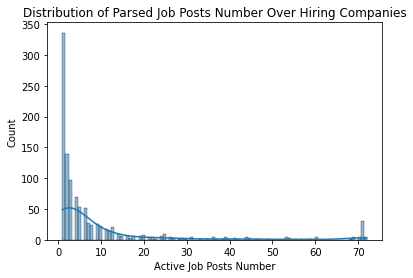

In [0]:
sns.histplot(jobs_parsed_stats["jobs_per_comp"], bins=100, kde=True)
plt.xlabel("Active Job Posts Number")
plt.ylabel("Count")
plt.title("Distribution of Parsed Job Posts Number Over Hiring Companies")
plt.show()

In [0]:
contents = {}
for url, jobs_list in jobs_dict.items():
    for index, job in enumerate(jobs_list):
        for key, value in job.items():
            if key in contents:
                contents[key].append(str(value).lower().replace('.', ''))
            else:
                contents[key] = [str(value).lower().replace('.', '')]

In [0]:
list(contents.keys())

Out[46]: ['Job Title and Summary',
 'Company Overview',
 'Job Responsibilities',
 'Qualifications and Skills',
 'Required Education',
 'Benefits and Perks',
 'Application Process',
 'Contact Information']

In [0]:
contents_counts = {key: dict(sorted(Counter(contents[key]).items(), key=lambda x: x[1], reverse=True)) for key in contents}

In [0]:
contents_keys = list(contents.keys())
print(contents_keys[2])
filtered_counts = {key: value for key, value in contents_counts[contents_keys[2]].items() if value > 1 and len(key) <= 50}
print(len(filtered_counts))
filtered_counts

Job Responsibilities
6
Out[48]: {'[]': 136,
 "['fix cars', 'work directly with customers']": 5,
 "['solve data structures and algorithms problems']": 4,
 "['fix cars', 'work on cars']": 3,
 "['fix cars']": 2,
 "['provide in-home child care']": 2}

In [0]:
bad_content = ['n/a', 'none', 'na', ' ']
bad_content_substr = ['not mentioned', 'not specified', 'not provided', 'none specified', 'no info',
               'none provided', 'no information provided', 'none mentioned', 'not available', 'no data',
               'not explicitly stated', 'unprovided']

In [0]:
 job_keys = {
    'Job Title and Summary': "",
    'Company Overview': "",
    'Job Responsibilities': [],
    'Qualifications and Skills': [],
    'Required Education': "",
    'Benefits and Perks': [],
    'Application Process': "",
    'Contact Information': ""
    }

In [0]:
for url, jobs_list in jobs_dict.items():
    for index, job in enumerate(jobs_list):
        for key, value in job.items():
            value_str = str(value).lower().replace('.', '')
            if key in job_keys and \
            (any(value_str == bad for bad in bad_content) \
             or any(bad in value_str for bad in bad_content_substr) \
             or type(value) != type(job_keys[key])):
                jobs_dict[url][index][key] = job_keys[key]
        for key in job_keys:
            if key not in job:
                jobs_dict[url][index][key] = job_keys[key]

In [0]:
incorrect_jobs = {}
for url, jobs_list in jobs_dict.items():
    for index, job in enumerate(jobs_list):
        for key in job:
            if key not in job_keys:
                if url in incorrect_jobs:
                    incorrect_jobs[url].append({index: key})
                else:
                    incorrect_jobs[url] = [{index: key}]
            elif type(job[key]) != type(job_keys[key]):
                if url in incorrect_jobs:
                    incorrect_jobs[url].append({index: (key, job[key])})
                else:
                    incorrect_jobs[url] = [{index: (key, job[key])}]

In [0]:
incorrect_jobs

Out[53]: {}

In [0]:
renamed_job_keys = {
    'Job Title and Summary': "title_and_summary",
    'Company Overview': "company_overview",
    'Job Responsibilities': "responsibilities",
    'Qualifications and Skills': "qualifications_and_skills",
    'Required Education': "education",
    'Benefits and Perks': "benefits",
    'Application Process': "application",
    'Contact Information': "contact_info"
    }

In [0]:
for url, jobs_list in jobs_dict.items():
    for i, job in enumerate(jobs_list):
        for key in renamed_job_keys:
            jobs_dict[url][i][renamed_job_keys[key]] = jobs_dict[url][i].pop(key)

In [0]:
for url, jobs_list in jobs_dict.items():
    for i, job in enumerate(jobs_list):
        for key in other_keys:
            try:
                jobs_dict[url][i][key] = jobs_dict_raw[url][i][key]
            except:
                print(f"{url=}, {len(jobs_dict_raw[url])=}, {i=}")
                print(f"{jobs_dict[url][i]=}")

In [0]:
next(iter(jobs_dict.values()))[0].keys()

Out[58]: dict_keys(['title_and_summary', 'company_overview', 'responsibilities', 'qualifications_and_skills', 'education', 'benefits', 'application', 'contact_info', 'title', 'description', 'location', 'post_time', 'criterias', 'url', 'datetime'])

In [0]:
import pickle

jobs_pickle_path = "/Workspace/Users/vladklim@campus.technion.ac.il/Project/jobs_parsed_dict.pickle"
with open(jobs_pickle_path, "wb") as f:
    pickle.dump(jobs_dict, f)

In [0]:
other_keys = ['title', 'description', 'location', 'post_time', 'criterias', 'url', 'datetime', 'benefits']
inner_schema = StructType([
    StructField(renamed_job_keys["Job Title and Summary"], StringType(), True),
    StructField(renamed_job_keys["Company Overview"], StringType(), True),
    StructField(renamed_job_keys["Job Responsibilities"], ArrayType(StringType()), True),
    StructField(renamed_job_keys["Qualifications and Skills"], ArrayType(StringType()), True),
    StructField(renamed_job_keys["Required Education"], StringType(), True),
    StructField(renamed_job_keys["Benefits and Perks"], ArrayType(StringType()), True),
    StructField(renamed_job_keys["Application Process"], StringType(), True),
    StructField(renamed_job_keys["Contact Information"], StringType(), True),
    *[StructField(key, StringType(), True) for key in other_keys]
])

outer_schema = StructType([
    StructField("url", StringType(), False),
    StructField("jobs_parsed", ArrayType(inner_schema), False)
])

jobs_parsed_df = spark.createDataFrame([(url, jobs_list) for url, jobs_list in jobs_dict.items()], ["url", "jobs_parsed"], outer_schema)
jobs_parsed_df.write.parquet("/Workspace/Users/vladklim@campus.technion.ac.il/Project/jobs_parsed.parquet", mode="overwrite")


In [0]:
jobs_parsed_df.display()

url jobs_parsed https://www.linkedin.com/company/honest-networks List(Map(application -> , company_overview -> Honest Networks is a venture-backed internet provider that provides gigabit internet service at affordable prices with exceptional customer service., benefits -> null, title_and_summary -> Honest Field Technician, location -> New York, NY, url -> https://www.linkedin.com/jobs/view/field-technician-telecommunications-construction-at-honest-networks-3646112649?refId=rZwvdLHKJcPci%2FgZ1ovyPw%3D%3D&trackingId=dh7a5bFtlVZbYnD8aQ6MnQ%3D%3D&position=7&pageNum=0&trk=public_jobs_jserp-result_search-card, description -> 
 Role Honest Field Technicians would be responsible for constructing and building out our network in residential apartment complexes and office buildings in NYC, Northern NJ & Stamford, CT Technicians (a) run fiber and ethernet through building risers; (b) mount and install networking equipment in MDF/IDF closets, and (c) set up and align radios on rooftops This is a fast-paced environment where you are likely working with 1 other person, setting up 2-3 buildings per month Personal attributes Comfortable working in a fast-paced environment Experience working with hand/power tools Excited to learn: we are looking for technicians who have strong technical competency but are always interested in continuously learning Problem solving attitude: able to troubleshoot issues About Honest Networks, Inc. Honest Networks believes high-quality and affordable internet service is a great enabler for our communities, providing the fundamental infrastructure to learn, create and enjoy. We are a fast-growing, venture-backed, internet provider headquartered in downtown Manhattan. We are focused on providing the gigabit internet service at affordable, transparent prices, with exceptional customer service. We do this by employing employees with high integrity, a strong work ethic and a passion for learning. If working in a fast-paced, results-oriented and mission-driven environment excites you, we encourage you to apply and join our team. Learn more at www.honest.net. Requirements 1-3 year experience with fiber optic, ethernet cable or electrician/conduit work Technical skills Ability to run fiber and cat5e/6 cabling through a large multi-tenant building (office, apartment complex); ability to install, terminate, and test and troubleshooting network cabling, including through existing interior and exterior conduit Ability to power and test networking switches and other networking hardware Bonus: ability to terminate fiber Comfortable using mass transit operate during the day Comfortable working in high-rises and on rooftops Ability to read, understand and follow work orders & change orders Capable of lifting up to 50 pounds Comfortable working in confined spaces Bonus Ability to bend pipe up to 1", Knowledge of DC power Benefits Attractive salary (estimate of $26-35/hr) based on capabilities and background Performance bonus potential Stock options Paid-time off (PTO) Medical and dental benefits Metro card reimbursement 
, datetime -> 2023-06-01, post_time -> 10 months ago, qualifications_and_skills -> [1-3 years of experience with fiber optic, ethernet cable, electrician/conduit work, Ability to run fiber and cat5e/6 cabling through large multi-tenant buildings, Ability to install, terminate, and test and troubleshoot network cabling, Ability to power and test networking switches and other networking hardware, Comfortable using mass transit, Comfortable working in high-rises and on rooftops, Capable of lifting up to 50 pounds, Comfortable working in confined spaces], contact_info -> , education -> , criterias -> {Industries=Technology, Information and Internet, Employment type=Full-time, Job function=Information Technology, Seniority level=Entry level}, title -> Field Technician - Telecommunications Construction, responsibilities -> [Constructing and building out network in residential apartment complexes and office buildings, Run